In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math

# Importing the dataset

In [2]:
polish_data = pd.read_csv(r"polish_data.csv")
print(polish_data.head())

   time  delta_time        X        Y  rot  Vmps  rot_sec
0     0           0  6062445  4368335  3.8   5.2     0.13
1    11          11  6062500  4368343  5.1   5.2     0.12
2    20           9  6062556  4368351  6.3   5.2    -0.10
3    29           9  6062600  4368359  5.3   5.4     0.35
4    39          10  6062655  4368367  8.8   5.3    -0.12


## Adding onbservations at each index $\Delta t = 1$

In [3]:
#Get the last time index
last_time = polish_data.iloc[-1][0]
upper_time = int(math.ceil(last_time / 10.0)) * 10 #rounding to nearest 10
upper_time

time_temp = np.arange(0,upper_time,1)


insert_blank = pd.DataFrame({'time': 0,"delta_time":1,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])
new_polish_dat =  pd.DataFrame({'time': 0,"delta_time":1,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])

k=0

for i in time_temp:
    insert_blank = pd.DataFrame({'time': i,"delta_time":1,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])
    if(time_temp[i] !=  int(polish_data.iloc[k][0])):
        new_polish_dat =pd.concat([new_polish_dat, insert_blank])
    else:
        new_polish_dat = pd.concat([new_polish_dat, pd.DataFrame.transpose(pd.DataFrame(polish_data.iloc[k]))])
        k += 1
        

In [4]:
pd.DataFrame.transpose(pd.DataFrame(polish_data.iloc[0]))

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0.0,0.0,6062445.0,4368335.0,3.8,5.2,0.13


In [5]:
new_kalman_data = new_polish_dat
new_kalman_data

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0.0,1.0,0.0,0.0,0.0,0.0,0.00
0,0.0,0.0,6062445.0,4368335.0,3.8,5.2,0.13
0,1.0,1.0,0.0,0.0,0.0,0.0,0.00
0,2.0,1.0,0.0,0.0,0.0,0.0,0.00
0,3.0,1.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...
0,375.0,1.0,0.0,0.0,0.0,0.0,0.00
0,376.0,1.0,0.0,0.0,0.0,0.0,0.00
0,377.0,1.0,0.0,0.0,0.0,0.0,0.00
0,378.0,1.0,0.0,0.0,0.0,0.0,0.00


## Conversion functions:

In [6]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def rot_min_to_sec(rot_min):
    return rot_min/60

def knots_to_mps(kts):
    return kts*0.51444444

In [7]:
def get_state_vector_Xk(data_frame, stateNo):

    # X coordinate    
    X_coord = data_frame.iloc[stateNo,2]

    # Y coordinate
    Y_coord = data_frame.iloc[stateNo,3]

    # Speed over ground
    sog = data_frame.iloc[stateNo,5]
    
    # Course over ground
    cog = data_frame.iloc[stateNo,4]

    
    # return state
    X_k = np.array([
            [X_coord],
           [Y_coord],
           [sog*np.cos(deg_to_rad(cog))], 
           [sog*np.sin(deg_to_rad(cog))]])
    
    return X_k
    

## Formulas fo the excelleration in the X and Y axis:

In [8]:
def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A


In [9]:
def est_coord_X_Y(a_x, a_y, prev_X, prev_Y, deltaTime):
    X_k = prev_X + a_x*deltaTime*deltaTime/2
    Y_k = prev_Y + a_y*detlaTime*deltaTime/2
    
    return X_k, Y_k

In [10]:
def predict_state(A,X_prev, a_x,a_y,deltaTIME):
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

### Getting the state vector if we are only predicting:

In [11]:
def get_state_vector_Xk_finalDF(data_frame, stateNo):

    #X coordinate    
    X_coord = data_frame.iloc[stateNo,0]
    X_coord_1 = data_frame.iloc[stateNo-1,0]

    #Y coordinate
    Y_coord = data_frame.iloc[stateNo,1]
    Y_coord_1 = data_frame.iloc[stateNo-1,1]

    #Vk - speed over ground
    sog = np.sqrt(data_frame.iloc[stateNo,2]**2 + data_frame.iloc[stateNo,3]**2)
    
    #Course over ground
    cog = np.arctan((Y_coord-Y_coord_1)/(X_coord-X_coord_1))

    
    #retunr state
    X_k = np.array([
            [X_coord],
           [Y_coord],
           [sog*np.cos(deg_to_rad(cog))], 
           [sog*np.sin(deg_to_rad(cog))]])
    return X_k

## Predicting the Proccess error covariance $P_{k}^{-}$ :

In [12]:
def pred_err_cov(A, P_k_1,Q):
    return A.dot(P_k_1).dot(np.transpose(A)) + Q

## Kalman gain $K_k$ :

In [13]:
def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

## A posteriori estimate $\hat{x}_k$ :

In [14]:
def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

## Update proccess error cov $P_k$

In [15]:
def adjust_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

## Getting the length of the dataset

In [16]:
data_length = len(new_kalman_data)

In [17]:
def calc_a_x_y(data_frame, stateNo, deltaTime):

    #Vk - speed over ground metre per second
    sog = data_frame.iloc[stateNo,5]    
    
    #Vk_1 
    sog_1 = data_frame.iloc[stateNo-1,5]   
    #Course over ground - current state 
    cog = data_frame.iloc[stateNo,4]    
    #Course over ground - previous state
    cog_prev = data_frame.iloc[stateNo-1,4]    
    #Rate of turn - degrees per second
    rot = data_frame.iloc[stateNo,6]
    
    # X-Acceleration    
    top_x = sog*np.cos(deg_to_rad(cog) + deg_to_rad(rot*deltaTime)) - sog_1*np.cos(deg_to_rad(cog_prev))
    a_x = top_x/deltaTime
    
    # Y-Acceleration  
    top_y = sog*np.sin(deg_to_rad(cog) + deg_to_rad(rot*deltaTime)) - sog_1*np.sin(deg_to_rad(cog_prev))
    a_y = top_y/deltaTime
    
    
    return a_x, a_y


# Setting up prediction & Kalman filtering:

In [37]:
# Setting up a prediction dataFrame
df_final = pd.DataFrame()
df_final.drop(df_final.index, inplace=True) #Clear DataFRAME
df_final = pd.DataFrame({"X_pred":0,"Y_pred":0, "Lin_spd_X":0, "Lin_spd_Y":0}, index = [0])



#Appending the first values to the dataframe
my_State_Vec = get_state_vector_Xk(new_kalman_data,0)
df_final = df_final.append(pd.DataFrame({"X_pred":my_State_Vec[0],
                                         "Y_pred":my_State_Vec[1],
                                         "Lin_spd_X":my_State_Vec[2],
                                         "Lin_spd_Y":my_State_Vec[3]}, index = [1]))

#------------------------------------------Setting up the KALMAN VARIABLES --------------------------------------
P_k =  np.array([[10],[10],[0.5],[0.5]]).dot(np.transpose(np.array([[10],[10],[0.5],[0.5]]))) #according to the IMO.
Q = P_k
H = np.identity(4)
R = np.diag(np.diag(P_k))
I = np.identity(4)
#------------------------------------------END KALMAN VARIABLES --------------------------------------

a_x_save = []

mycounter = 0
for i in range(1,data_length): 
    a_x = 0
    a_y = 0
    
    
    #If we have the real value do this:
    if(int(new_kalman_data.iloc[i,3]) != 0):
        #If we have the value, we will need to do a prediction with a correction
        #deltaTIME = polish_data.iloc[mycounter,1]
        
        deltaTIME = 1
        A = get_mat_A(1)
        
        if(i == 1):
            
            ######### Getting the values for the update ##################
            state_vector = get_state_vector_Xk(new_kalman_data, i)
            a_x, a_y = calc_a_x_y(new_kalman_data,i,1)
            a_x_save.append(a_x)
            
            
            # ----------------- STARTING THE KALMAN PROCESS-----------------
            # PREDICT A STATE            
            predicted_State = predict_state(A,state_vector,a_x, a_y,deltaTIME)
            P_k =  pred_err_cov(A, P_k, Q)
            
    
            #---------------------------- UPDATE -------------------------:
            # Kalman Gain
            K_k = Kalman_gain(P_k, H, R)         
            # a posteriori estimate
            x_k = adjust_pred_state(predicted_State, K_k,state_vector,H)           
            # proccess covariance update
            P_k = adjust_err_cov(I,K_k,H,P_k)
         
            df_final = df_final.append(pd.DataFrame({"X_pred":x_k[0],
                                         "Y_pred":x_k[1],
                                         "Lin_spd_X":x_k[2],
                                         "Lin_spd_Y":x_k[3]}, index = [1]))
            
    
        else:
            # We want to update the filter estimates
            
            #---------------------------- PREDICTION --------------------:
            state_vector = get_state_vector_Xk(new_kalman_data, i)
            a_x, a_y = calc_a_x_y(new_kalman_data,i,deltaTIME) 
            a_x_save.append(a_x_save)
            
            
            predicted_State = predict_state(A,state_vector,a_x, a_y,1)
            P_k =  pred_err_cov(A,P_k,Q)
            
            #---------------------------- UPDATE -------------------------:
            # Kalman Gain
            K_k = Kalman_gain(P_k, H, R)         
            # a posteriori estimate
            x_k = adjust_pred_state(predicted_State, K_k,state_vector,H)

            # proccess covariance update
            P_k = adjust_err_cov(I,K_k,H,P_k)
                        
            df_final = df_final.append(pd.DataFrame({"X_pred":x_k[0],
                                         "Y_pred":x_k[1],
                                         "Lin_spd_X":x_k[2],
                                         "Lin_spd_Y":x_k[3]}, index = [1]))
        
        mycounter += 1

    else:
        A = get_mat_A(1)
        #If we do not have the value, just predict a state ahead and append to dataset
        state_vector = get_state_vector_Xk_finalDF(df_final, i)
        a_x = 0
        a_y = 0
        predicted_State = predict_state(A,state_vector,a_x, a_y,1)
        P_k =  pred_err_cov(A,P_k,Q)
        
        # Kalman Gain
        K_k = Kalman_gain(P_k, H, R)         
        # a posteriori estimate
        x_k = adjust_pred_state(predicted_State, K_k,state_vector,H)
        # proccess covariance update
        P_k = adjust_err_cov(I,K_k,H,P_k)
                        

        
        


        df_final = df_final.append(pd.DataFrame({"X_pred":predicted_State[0],
                                         "Y_pred":predicted_State[1],
                                         "Lin_spd_X":predicted_State[2],
                                         "Lin_spd_Y":predicted_State[3]}, index = [1]))


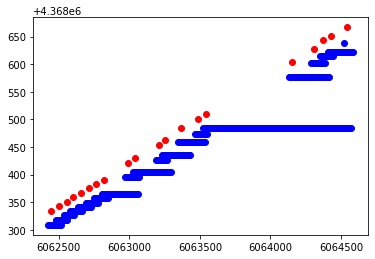

In [38]:
x_pred = df_final.iloc[:,0].values
y_pred = df_final.iloc[:,1].values



plt.plot(x_pred[np.arange(2,len(x_pred),1)],y_pred[np.arange(2,len(x_pred),1)], "bo")
plt.plot(polish_data.iloc[:,2].values ,polish_data.iloc[:,3].values, "ro")


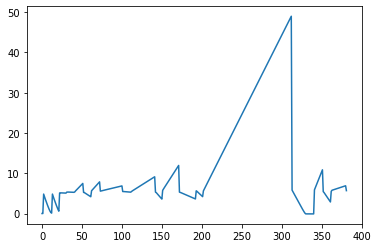

In [20]:
plt.plot(np.arange(0,len(df_final.iloc[:,3])),df_final.iloc[:,2])

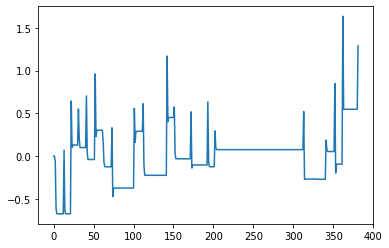

In [21]:
plt.plot(np.arange(0,len(df_final.iloc[:,3])),df_final.iloc[:,3])

In [22]:
df_final

,X_pred,Y_pred,Lin_spd_X,Lin_spd_Y
0,0.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000e+00,0.000000e+00,0.000000,0.000000
1,6.062463e+06,4.368348e+06,4.828571,-0.060907
1,6.062468e+06,4.368348e+06,4.206075,-0.615505
1,6.062472e+06,4.368348e+06,3.628276,-0.672745
...,...,...,...,...
1,6.064520e+06,4.368649e+06,6.699537,0.547777
1,6.064527e+06,4.368649e+06,6.763246,0.547777
1,6.064534e+06,4.368650e+06,6.826745,0.547776
1,6.064541e+06,4.368650e+06,6.890039,0.547776


In [23]:
new_kalman_data.iloc[12,1]
polish_data

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0,0,6062445,4368335,3.8,5.2,0.13
1,11,11,6062500,4368343,5.1,5.2,0.12
2,20,9,6062556,4368351,6.3,5.2,-0.10
3,29,9,6062600,4368359,5.3,5.4,0.35
4,39,10,6062655,4368367,8.8,5.3,-0.12
5,50,11,6062711,4368375,7.6,5.5,-0.42
6,60,10,6062766,4368383,3.4,5.5,0.33
7,71,11,6062822,4368391,6.7,5.5,-0.29
8,99,28,6062988,4368422,3.8,5.6,0.50
9,110,11,6063043,4368430,8.8,5.4,-0.07


In [24]:
polish_data.iloc[1,1]

11

In [25]:
polish_data

,time,delta_time,X,Y,rot,Vmps,rot_sec
0,0,0,6062445,4368335,3.8,5.2,0.13
1,11,11,6062500,4368343,5.1,5.2,0.12
2,20,9,6062556,4368351,6.3,5.2,-0.10
3,29,9,6062600,4368359,5.3,5.4,0.35
4,39,10,6062655,4368367,8.8,5.3,-0.12
5,50,11,6062711,4368375,7.6,5.5,-0.42
6,60,10,6062766,4368383,3.4,5.5,0.33
7,71,11,6062822,4368391,6.7,5.5,-0.29
8,99,28,6062988,4368422,3.8,5.6,0.50
9,110,11,6063043,4368430,8.8,5.4,-0.07


In [26]:
polish_data.iloc[1,4]

5.1